In [3]:
import numpy as np
from pathlib import Path
from astropy.io import fits
from astropy.table import Table, vstack, hstack, unique,join
import matplotlib.pyplot as plt
import pandas as pd
import sys

# sys.path.append("/global/u2/b/bid13/VI/prospect/py")

import desispec.coaddition
import desispec.io
import desispec.spectra
# from desitarget.cmx.cmx_targetmask import cmx_mask
from desitarget.sv1.sv1_targetmask import desi_mask
from prospect import utilities,plotframes, myspecselect, myspecupdate
from desispec.coaddition import coadd_cameras
from prospect import utilities ,plotframes
# from prospect_my import plotframes

from stack_spectra import _common_grid

In [4]:
my_path = Path("/global/cscratch1/sd/bid13/stack-spectra")

In [92]:
spec = desispec.io.read_spectra(my_path /  "spectra_bright.fits")#coadd_cam_bright.fits")
zcat = Table.read(my_path / "zcat_bright.fits")
flux = spec.flux['r']
wl = spec.wave['r']
ivar = spec.ivar['r']

INFO:spectra.py:253:read_spectra: iotime 0.082 sec to read spectra_bright.fits at 2021-04-13T11:45:13.716780


In [6]:
print(np.shape(flux),np.shape(ivar),np.shape(zcat['Z']))

(16, 2326) (16, 2326) (16,)


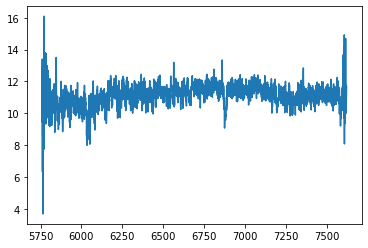

In [7]:
plt.plot(wl,flux[1])

In [8]:
def normalize(flux,ivar):
    norm = np.nanmedian(flux,axis=1).reshape(np.shape(flux)[0],1)
    flux = flux/norm
    ivar = ivar*norm**2
    
    return ivar, flux

In [105]:
def wavg(flux,ivar=None,weighted=False, weights = None):
    if weighted:
        num = np.nansum(flux*weights,axis=0)
        denom = np.nansum(weights,axis=0)
    
        if 0. in denom:
            denom[denom==0.0] = np.nan
    
        avg = np.nan_to_num(num/denom)
    else:
        avg = np.mean(flux,axis=0)
        
    ivar = np.nansum(ivar,axis = 0)
    
    return avg, ivar

In [98]:
new_f,new_i,new_wl = _common_grid(flux, wl, ivar, zcat['Z'], z_out=0.0, wave_grid=None)

In [99]:
i,f = normalize(new_f,new_i)

In [106]:
wavg_f, wavg_ivar = wavg(f,ivar = ivar)

In [112]:
## Bootstrap

In [75]:
ndata = np.shape(new_f)[0]
len_spec = np.shape(new_f)[1]
nbootstraps=10
boot = np.zeros((nbootstraps,len_spec))
nsamples=int(1E2)

In [83]:
def _bootstrap(flux_spec,ndata,nbootstraps,nsamples,len_spec):
    
    stacks = np.zeros((nbootstraps,len_spec))
    for j in range(nbootstraps):
        boot = np.zeros((nsamples,len_spec))
        for i in range(nsamples):
            idx=np.random.choice(ndata,1,replace=True)
            boot[i]+=flux_spec[idx][0]
        stacks[j] += wavg(boot)
    
    ivar = 1.0/(np.nanstd(stacks,axis=0))**2
    
    return stacks,ivar

In [84]:
stacks, ivar = _bootstrap(new_f,ndata,nbootstraps,nsamples,len_spec)

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [87]:
ivar

array([nan, nan, nan, ..., nan, nan, nan])

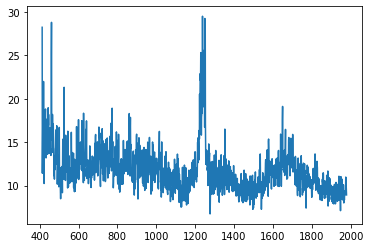

In [88]:
#for i in range(nbootstraps):
plt.plot(ivar)
#plt.plot(new_wl,wavg_f)